<a href="https://colab.research.google.com/github/yumehara/hackday_2022/blob/main/notebooks/all_city_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 市区町村別の項目別スコア

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -q japanize-matplotlib

import os
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np

In [3]:
DIR_NAME = '/content/drive/MyDrive/hackday/'

## 市区町村ごとの歳出データ
- [令和4年版地方財政白書](https://www.soumu.go.jp/menu_seisaku/hakusyo/chihou/r04data/2022data/r04czb01-04.html)

In [4]:
df_spending = pd.read_csv(os.path.join(DIR_NAME, 'spending.csv'))
print(df_spending.shape)

(22525715, 12)


In [5]:
df_spending_2020 = df_spending[
    (df_spending['決算年度'] == 2020)&
    ((df_spending['団体名'].str.endswith('市')) | (df_spending['団体名'].str.endswith('区')) | 
     (df_spending['団体名'].str.endswith('町')) | (df_spending['団体名'].str.endswith('村')))
].rename(columns={'県名':'都道府県名', '団体名': '市区町村名'})

In [6]:
# 団体コードのチェックデジットを削除
df_spending_2020['団体コード'] = df_spending_2020['団体コード'].str[:-1].astype(int)

In [7]:
df_spending_pivot = pd.pivot_table(df_spending_2020, index=['都道府県名', '市区町村名', '団体コード'], columns='費目', values='金額', aggfunc='sum')
print(df_spending_pivot.shape)
df_spending_pivot.head()

(1741, 91)


費目                 001:労働費・総額  001:土木費・総額   001:歳出合計  001:民生費・総額  001:消防費  \
都道府県名 市区町村名 団体コード                                                           
三重県   いなべ市  24214           0     9014208   99565712    21758551  4807102   
      亀山市   24210       80088     9404990   94292138    22357159  3840773   
      伊勢市   24203      285681    24393028  242712808    62753501  8661119   
      伊賀市   24216      201105     8928857  187931118    46195125  6317500   
      南伊勢町  24472           0     4720829   40538629     9011457  2371116   

費目                 001:災害復旧費・総額  001:議会費  002:労働費・失業対策費  002:国庫支出金  \
都道府県名 市区町村名 団体コード                                                    
三重県   いなべ市  24214        356271   635112              0   27304046   
      亀山市   24210         15155   731031              0   33013471   
      伊勢市   24203        962601   954838              0   77795877   
      伊賀市   24216       1008853   887963              0   57575865   
      南伊勢町  24472        641318   247214              0    8299007   

費目                 002:土木費・土木管理費  ...  019:災害復旧費・その他・公立学校  020:災害復旧費・その他・公営住宅  \
都道府県名 市区町村名 団体コード                 ...                                           
三重県   いなべ市  24214         231294  ...                   0                   0   
      亀山市   24210         340421  ...                   0                   0   
      伊勢市   24203        3172211  ...                   0                   0   
      伊賀市   24216         485827  ...                   0                   0   
      南伊勢町  24472         212383  ...                   0                   0   

費目                 021:災害復旧費・その他・社会福祉施設  022:災害復旧費・その他・その他   023:公債費  \
都道府県名 市区町村名 団体コード                                                      
三重県   いなべ市  24214                     0                  0   8612472   
      亀山市   24210                     0                  0   5552331   
      伊勢市   24203                     0                  0  17104080   
      伊賀市   24216                     0             110010  17557143   
      南伊勢町  24472                     0                  0   3710979   

費目                 024:諸支出金・総額  025:諸支出金・普通財産取得費  026:諸支出金・公営企業費  \
都道府県名 市区町村名 団体コード                                                  
三重県   いなべ市  24214            0                 0               0   
      亀山市   24210            0                 0               0   
      伊勢市   24203            0                 0               0   
      伊賀市   24216            0                 0               0   
      南伊勢町  24472            0                 0               0   

費目                 027:諸支出金・市町村たばこ税都道府県交付金  028:前年度繰上充用金  
都道府県名 市区町村名 団体コード                                         
三重県   いなべ市  24214                        0             0  
      亀山市   24210                        0             0  
      伊勢市   24203                        0             0  
      伊賀市   24216                        0             0  
      南伊勢町  24472                        0             0  

[5 rows x 91 columns]

### RESASの人口ピラミッド

In [8]:
df_population = pd.read_csv(os.path.join(DIR_NAME, 'population_pyramid.csv'))
df_population['population'] = df_population['man'] + df_population['woman']
df_population.rename(columns={'prefName':'都道府県名', 'cityName':'市区町村名', 'cityCode':'団体コード'}, inplace=True)
print(df_population.shape)

(34390, 11)


In [9]:
df_population_pivot = df_population.pivot(index=['都道府県名', '市区町村名', '団体コード'], columns='class', values='population')
df_population_pivot['総人口'] = df_population_pivot.sum(axis=1)
print(df_population_pivot.shape)
df_population_pivot.head()

(1810, 20)


class              0～4歳  10～14歳  15～19歳  20～24歳  25～29歳  30～34歳  35～39歳  \
都道府県名 市区町村名 団体コード                                                         
三重県   いなべ市  24214  1675    2008    2031    2566    2784    2641    2666   
      亀山市   24210  2204    2350    2198    2118    2259    2959    3279   
      伊勢市   24203  4473    5362    5800    5522    5501    5996    6477   
      伊賀市   24216  2862    3537    3679    3485    3541    3881    4229   
      南伊勢町  24472   151     263     259     236     258     252     260   

class              40～44歳  45～49歳  50～54歳  55～59歳  5～9歳  60～64歳  65～69歳  \
都道府県名 市区町村名 団体コード                                                         
三重県   いなべ市  24214    2890    3265    3048    2895  1863    2663    2969   
      亀山市   24210    3521    4024    3199    2904  2218    2923    3181   
      伊勢市   24203    7447    9188    8356    8270  4962    7955    8580   
      伊賀市   24216    4924    5674    5022    5247  3126    5539    6429   
      南伊勢町  24472     343     528     666     785   193     839    1012   

class              70～74歳  75～79歳  80～84歳  85～89歳  90歳～     総人口  
都道府県名 市区町村名 団体コード                                                
三重県   いなべ市  24214    3169    2377    1728    1221   924   45383  
      亀山市   24210    3527    2572    1923    1429   996   49784  
      伊勢市   24203    9595    7527    6042    4452  2802  124307  
      伊賀市   24216    7066    5330    4357    3386  2709   84023  
      南伊勢町  24472    1199    1227    1113     773   480   10837

### 教育

In [10]:
df_school = pd.read_csv(os.path.join(DIR_NAME, 'school_agg.csv'))
print(df_school.shape)

(1917, 22)


### 治安(交通事故)

In [11]:
df_criminals = pd.read_csv(os.path.join(DIR_NAME, 'criminals.csv'))
print(df_criminals.shape)
df_criminals = df_criminals[df_criminals['調査年'] == '2009年度'][['area_code', 'value']].rename(columns={'area_code':'団体コード', 'value':'交通事故発生件数'})
df_criminals['交通事故発生件数'] = df_criminals['交通事故発生件数'].replace('-', np.NaN).astype(float)
print(df_criminals.shape)

(100000, 11)
(1963, 2)


### 病院

In [12]:
df_hospital = pd.read_csv(os.path.join(DIR_NAME, 'hospital.csv'))
print(df_hospital.shape)

(1917, 5)


## 全て結合

In [70]:
# 歳出 + 人口
df_city_all = pd.concat([df_spending_pivot, df_population_pivot], axis=1, sort=True).reset_index().sort_values('団体コード')
# + 学校
df_city_all = pd.merge(df_city_all, df_school.drop(columns=['市区町村名']), on='団体コード', how='left')
# + 交通事故
df_city_all = pd.merge(df_city_all, df_criminals, on='団体コード', how='left')
# + 病院
df_city_all = pd.merge(df_city_all, df_hospital.drop(columns=['市区町村名', '親_団体コード']), on='団体コード', how='left')
print(df_city_all.shape)

(1876, 137)


### 人口

In [71]:
# df_city_all['幼児人口'] = (df_city_all['0～4歳'] * 4/5 + df_city_all['5～9歳'] * 2/5).round()
# df_city_all['小学生人口'] = (df_city_all['5～9歳'] * 3/5 + df_city_all['10～14歳'] * 3/5).round()
# df_city_all['中学生人口'] = (df_city_all['10～14歳'] * 2/5 + df_city_all['15～19歳'] * 1/5).round()

# 年少人口（15歳未満）
df_city_all['年少人口'] = df_city_all['0～4歳'] + df_city_all['5～9歳'] + df_city_all['10～14歳']
# 生産年齢人口（15歳以上65歳未満）
df_city_all['生産年齢人口'] = (df_city_all['15～19歳'] + df_city_all['20～24歳'] + df_city_all['25～29歳'] + df_city_all['30～34歳'] + 
                                df_city_all['35～39歳'] + df_city_all['40～44歳'] + df_city_all['45～49歳'] + df_city_all['50～54歳'] + 
                                df_city_all['55～59歳'] + df_city_all['60～64歳'])
# 老年人口(65歳以上)
df_city_all['老年人口'] = (df_city_all['65～69歳'] + df_city_all['70～74歳'] + df_city_all['75～79歳'] + df_city_all['80～84歳'] + 
                                df_city_all['85～89歳'] + df_city_all['90歳～'])

# 年少人口指数 = 年少人口/生産年齢人口×100
df_city_all['年少人口指数'] = df_city_all['年少人口'] / df_city_all['生産年齢人口'] * 100
# 老年人口指数 = 老年人口/生産年齢人口×100
df_city_all['老年人口指数'] = df_city_all['老年人口'] / df_city_all['生産年齢人口'] * 100
# 従属人口指数 = (年少人口＋老年人口)/生産年齢人口×100
df_city_all['従属人口指数'] = (df_city_all['年少人口'] + df_city_all['老年人口']) / df_city_all['生産年齢人口'] * 100
# 老年化指数 = 老年人口/年少人口×100
df_city_all['老年化指数'] = df_city_all['老年人口'] / df_city_all['年少人口'] * 100

### 財政

In [72]:
df_city_all['人口一人当たりの歳出合計'] = df_city_all['001:歳出合計'] / df_city_all['総人口']
df_city_all['公債費比率'] = df_city_all['023:公債費'] / df_city_all['001:歳出合計'] * 100

### 教育

In [73]:
df_city_all['年少人口一人当たりの教育費総額'] = df_city_all['002:教育費・総額'] / df_city_all['年少人口']
df_city_all['年少人口一人当たりの保健体育・給食費'] = df_city_all['011:教育費・保健体育費・学校給食費'] / df_city_all['年少人口']
df_city_all['幼稚園児一人当たりの幼稚園費'] = df_city_all['008:教育費・幼稚園費'] / df_city_all['幼稚園_生徒数']
df_city_all['小学生一人当たりの小学校費'] = df_city_all['004:教育費・小学校費'] / df_city_all['小学校_生徒数']
df_city_all['中学生一人当たりの中学校費'] = df_city_all['005:教育費・中学校費'] / df_city_all['中学校_生徒数']

In [74]:
# df_city_all['高等学校_学級数'] = None
for school in ['中学校', '小学校', '幼稚園', '高等学校']:
    # df_city_all[f'{school}_学校当たりの生徒数'] = df_city_all[f'{school}_生徒数'] / df_city_all[f'{school}_学校数']
    # df_city_all[f'{school}_学校当たりの教員数'] = df_city_all[f'{school}_教員数'] / df_city_all[f'{school}_学校数']
    # df_city_all[f'{school}_学校当たりの職員数'] = df_city_all[f'{school}_職員数'] / df_city_all[f'{school}_学校数']
    # df_city_all[f'{school}_学級当たりの生徒数'] = df_city_all[f'{school}_生徒数'] / df_city_all[f'{school}_学級数']
    # df_city_all[f'{school}_学級当たりの教員数'] = df_city_all[f'{school}_教員数'] / df_city_all[f'{school}_学級数']
    df_city_all[f'{school}_教員一人当たりの生徒数'] = df_city_all[f'{school}_生徒数'] / df_city_all[f'{school}_教員数']
    # df_city_all[f'{school}_職員一人当たりの生徒数'] = df_city_all[f'{school}_生徒数'] / df_city_all[f'{school}_職員数']

In [75]:
# df_city_all['幼稚園_学校当たりの幼稚園費'] = df_city_all['008:教育費・幼稚園費'] / df_city_all['幼稚園_学校数']
# df_city_all['小学校_学校当たりの小学校費'] = df_city_all['004:教育費・小学校費'] / df_city_all['小学校_学校数']
# df_city_all['中学校_学校当たりの中学校費'] = df_city_all['005:教育費・中学校費'] / df_city_all['中学校_学校数']
# df_city_all['幼稚園_教員一人当たりの幼稚園費'] = df_city_all['008:教育費・幼稚園費'] / df_city_all['幼稚園_教員数']
# df_city_all['小学校_教員一人当たりの小学校費'] = df_city_all['004:教育費・小学校費'] / df_city_all['小学校_教員数']
# df_city_all['中学校_教員一人当たりの中学校費'] = df_city_all['005:教育費・中学校費'] / df_city_all['中学校_教員数']

### 社会福祉

In [76]:
df_city_all['人口一人当たりの民生費総額'] = df_city_all['001:民生費・総額'] / df_city_all['総人口']
df_city_all['年少人口一人当たりの児童福祉費'] = df_city_all['004:民生費・児童福祉費'] / df_city_all['年少人口']
df_city_all['老年人口一人当たりの老人福祉費'] = df_city_all['003:民生費・老人福祉費'] / df_city_all['老年人口']

### 医療

In [77]:
df_city_all['人口千人当たりの病院数'] = df_city_all['病院施設数'] / df_city_all['総人口'] * 1000
df_city_all['人口千人人当たりの病床数'] = df_city_all['病院病床数'] / df_city_all['総人口'] * 1000

### 治安

In [78]:
df_city_all['人口千人当たりの交通事故件数'] = df_city_all['交通事故発生件数'] / df_city_all['総人口'] * 1000

### 環境

In [79]:
df_city_all['人口一人当たりの公園費'] = df_city_all['007:土木費・都市計画費・公園費'] / df_city_all['総人口']

### 防災

In [80]:
df_city_all['人口一人当たりの消防費'] = df_city_all['001:消防費'] / df_city_all['総人口']
df_city_all['人口一人当たりの災害救助費'] = df_city_all['006:民生費・災害救助費'] / df_city_all['総人口']

In [81]:
df_city_all.to_csv(os.path.join(DIR_NAME, 'city_all.csv'), index=False)

In [82]:
plt.rcParams['axes.axisbelow'] = True
plt.rcParams["font.size"] = 14

In [83]:
def draw_bar_graph_by_city(df_data, col_name, x_col='市区町村名'):
    data = df_data.sort_values(col_name, ascending=False)[[x_col, col_name]]
    data.plot(x=x_col, kind='bar', title=col_name, figsize=(17, 5))
    mean = data[col_name].mean()
    plt.axhline(y=mean, xmin=0, xmax=1, color='red')
    plt.grid()
    plt.legend().remove()
    plt.show()

def draw_stacked_bar_graph_by_city(df_data, title, mean):
    df_data.plot(x='市区町村名', kind='bar', stacked=True, title=title, figsize=(17, 5))
    plt.axhline(y=mean, xmin=0, xmax=1, color='red')
    plt.grid()
    plt.show()

### 東京都(23区)と主要都市の比較

In [84]:
df_big_city = df_city_all[
    ((df_city_all['都道府県名'] == '東京都')&(df_city_all['市区町村名'].str.endswith('区')))|
    (df_city_all['市区町村名'].isin(['さいたま市', '横浜市', '名古屋市', '大阪市', '京都市', '神戸市', '福岡市']))
]

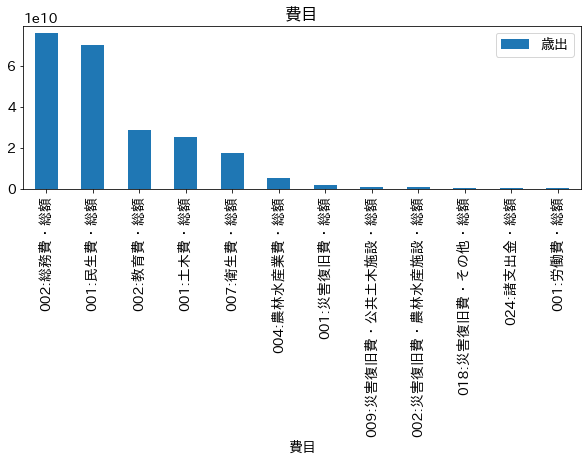

In [85]:
subtotal_col = [col for col in list(df_spending_pivot.columns) if '総額' in col]
df_subtotal = df_spending_pivot[subtotal_col].sum().rename('歳出').sort_values(ascending=False)
df_subtotal.reset_index().plot(x='費目', kind='bar', title='費目', figsize=(10, 3))
plt.show()

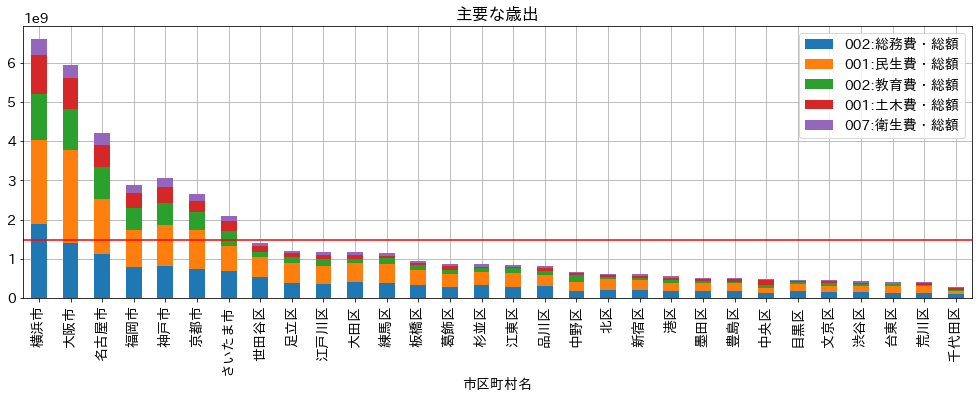

In [86]:
subtotal_top = list(df_subtotal.head(5).index)
draw_stacked_bar_graph_by_city(
    df_big_city.sort_values('001:歳出合計', ascending=False)[['市区町村名'] + subtotal_top],
    '主要な歳出',
    df_big_city[subtotal_top].sum(axis=1).mean()
)

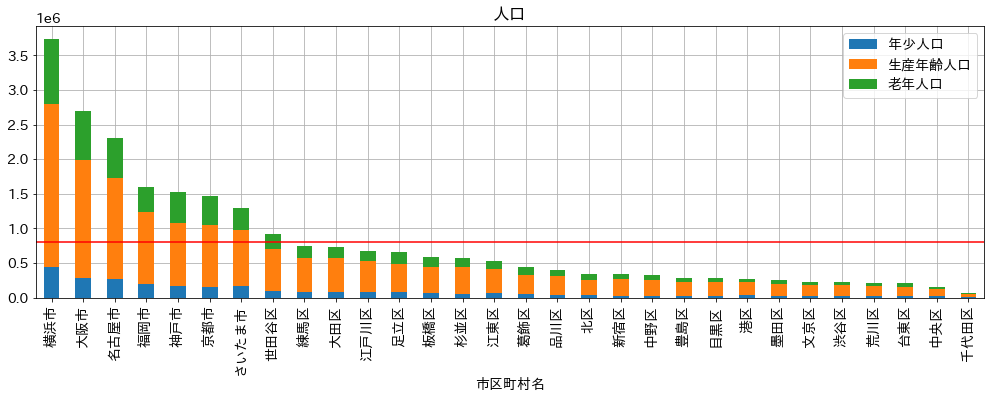

In [87]:
draw_stacked_bar_graph_by_city(
    df_big_city.sort_values('総人口', ascending=False)[['市区町村名', '年少人口', '生産年齢人口', '老年人口']], '人口',
    df_big_city['総人口'].mean()
)

### 人口指数

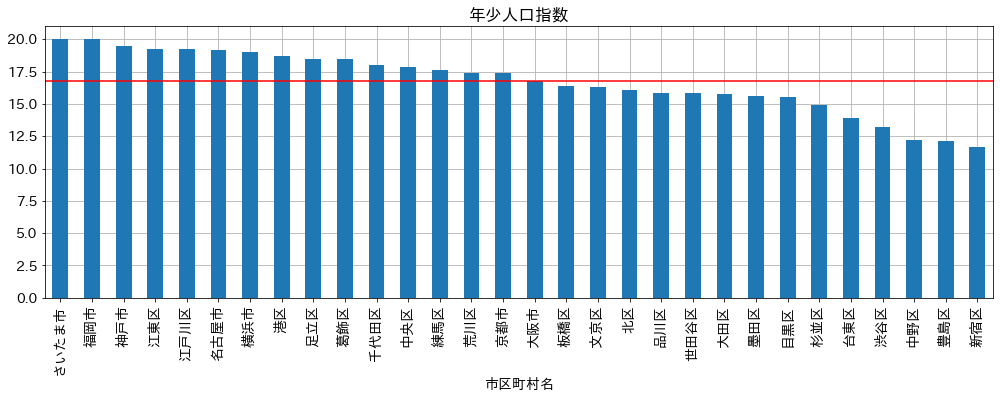

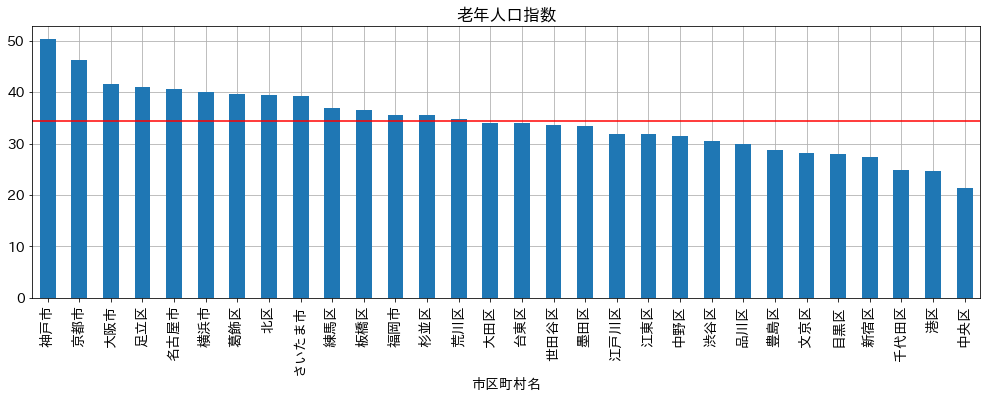

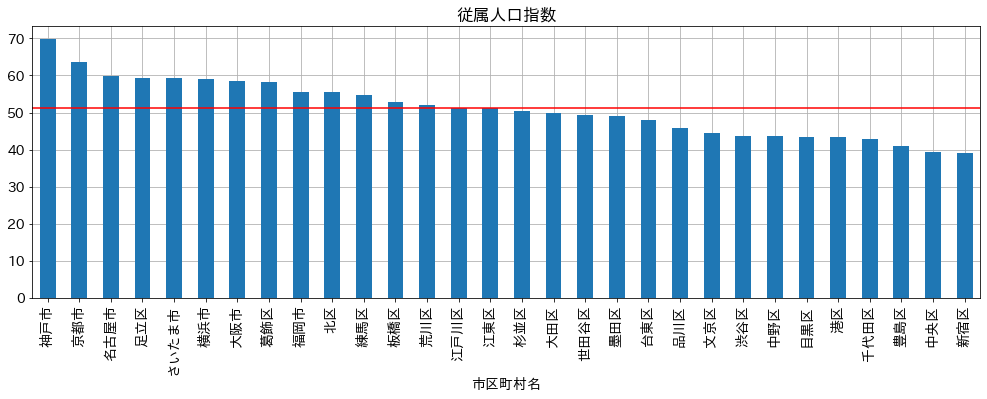

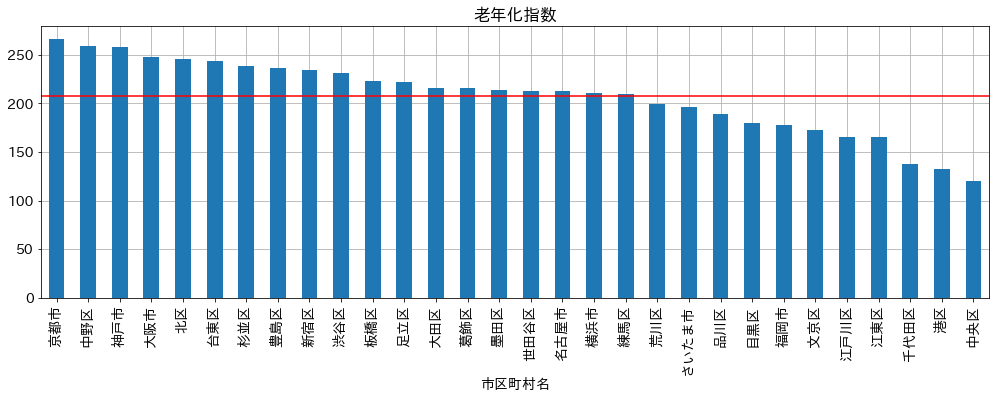

In [88]:
for col in ['年少人口指数', '老年人口指数', '従属人口指数', '老年化指数']:
    draw_bar_graph_by_city(df_big_city, col)

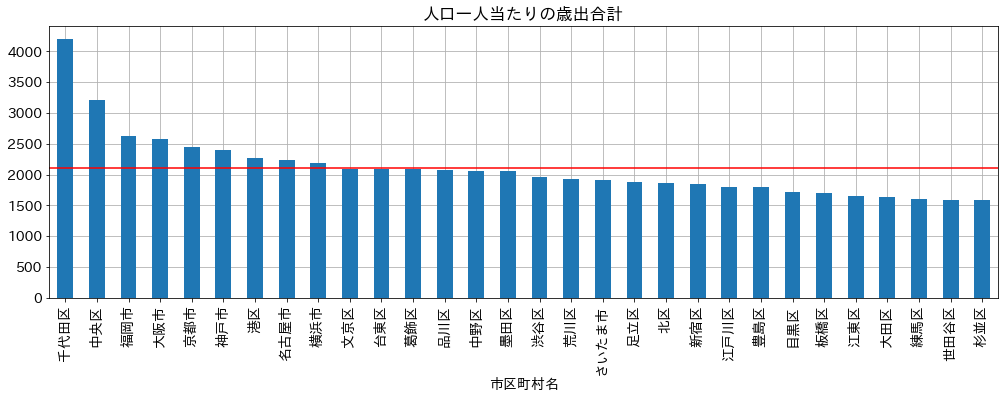

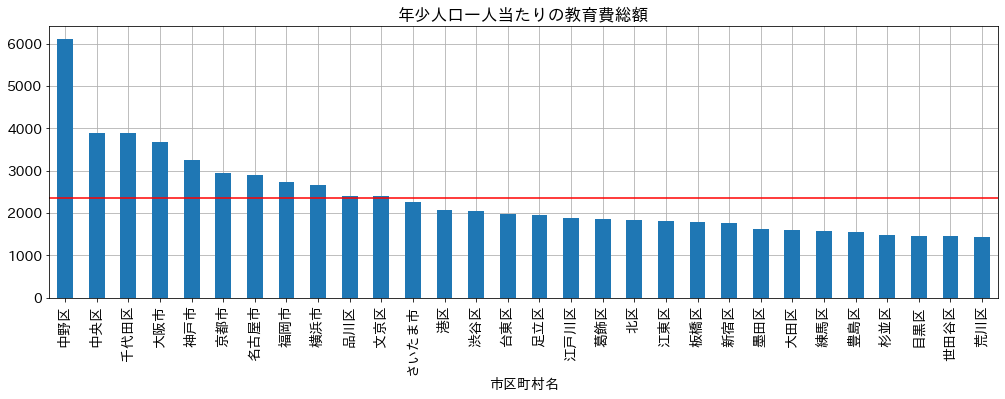

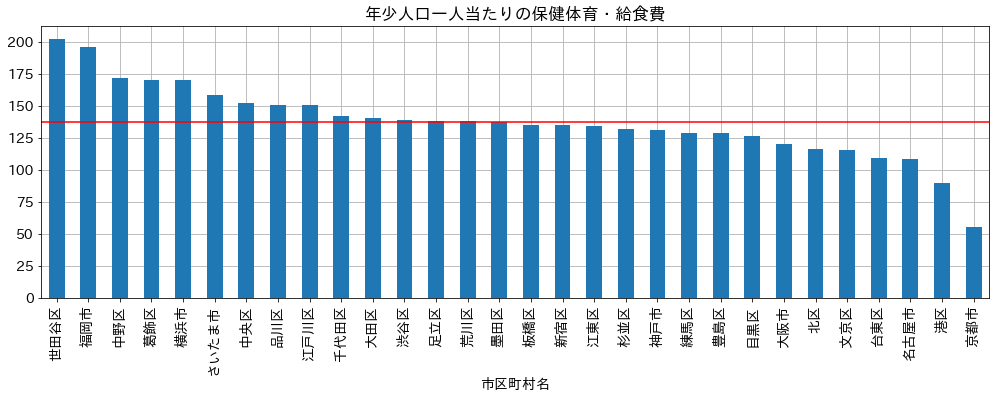

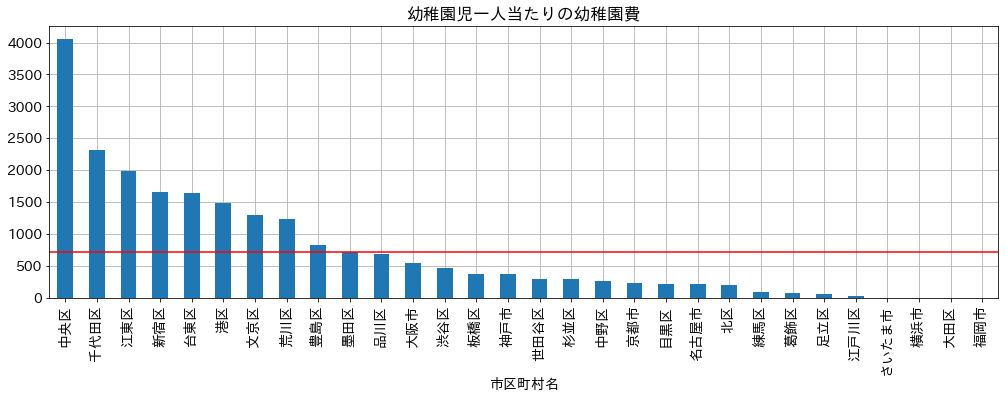

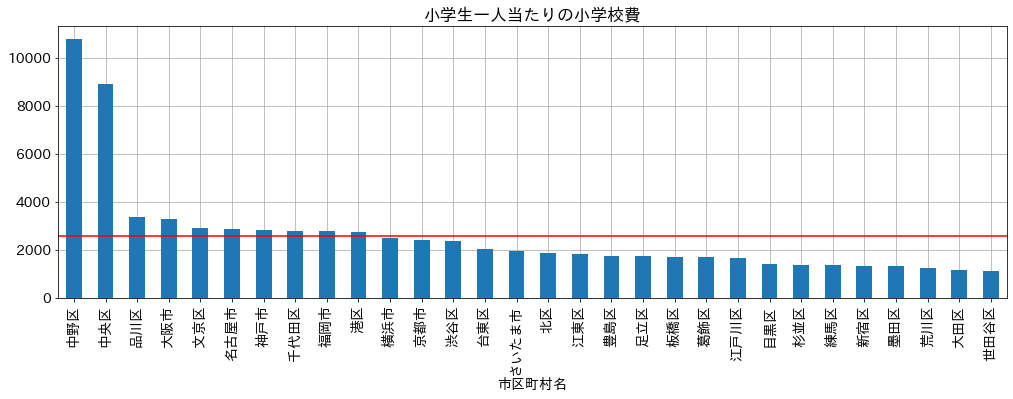

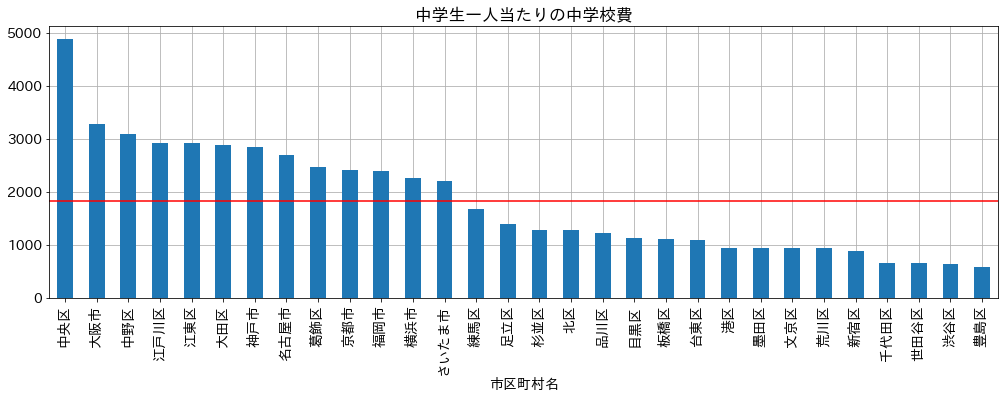

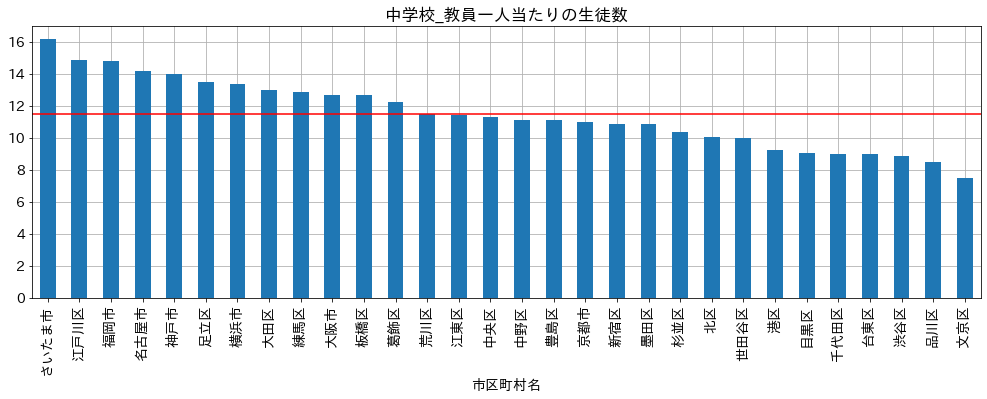

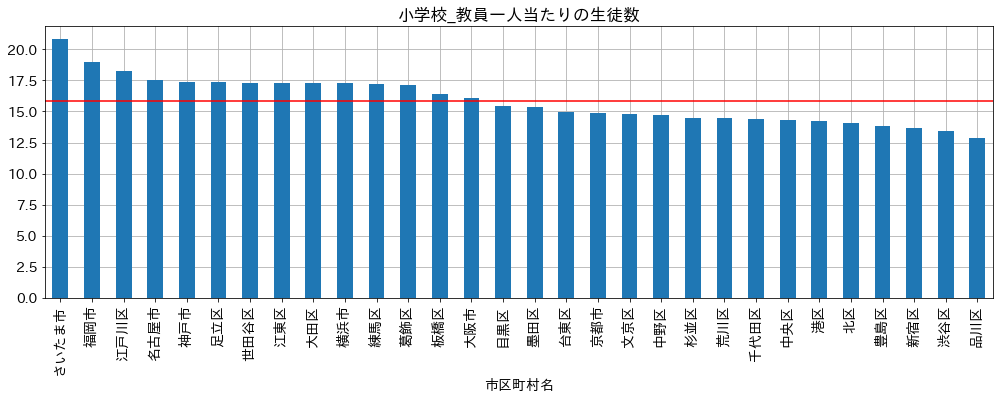

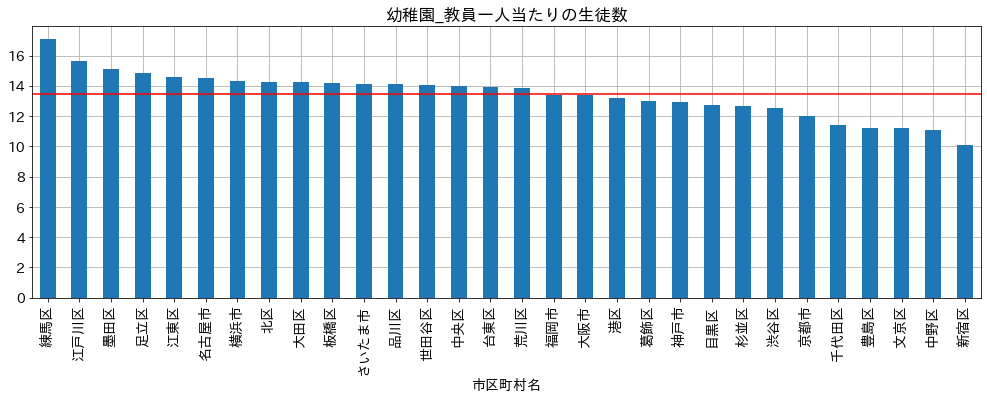

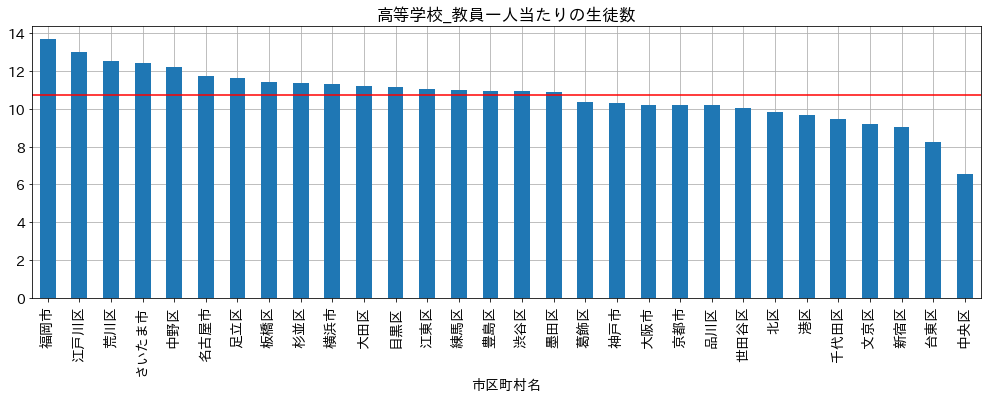

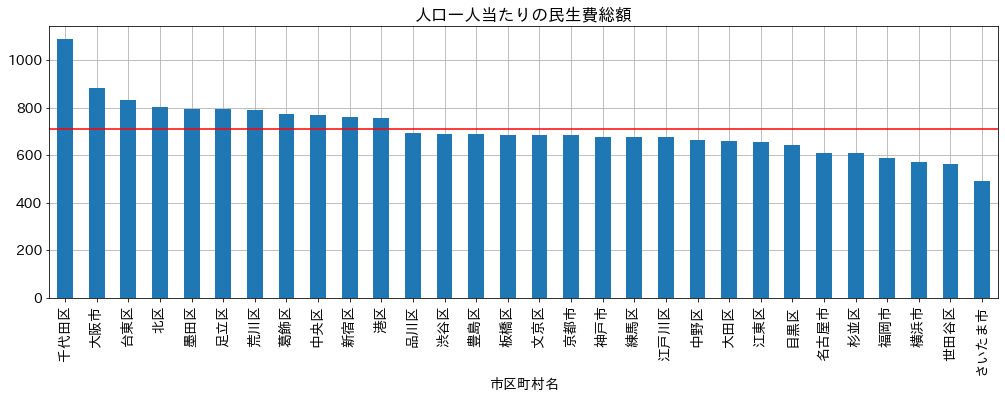

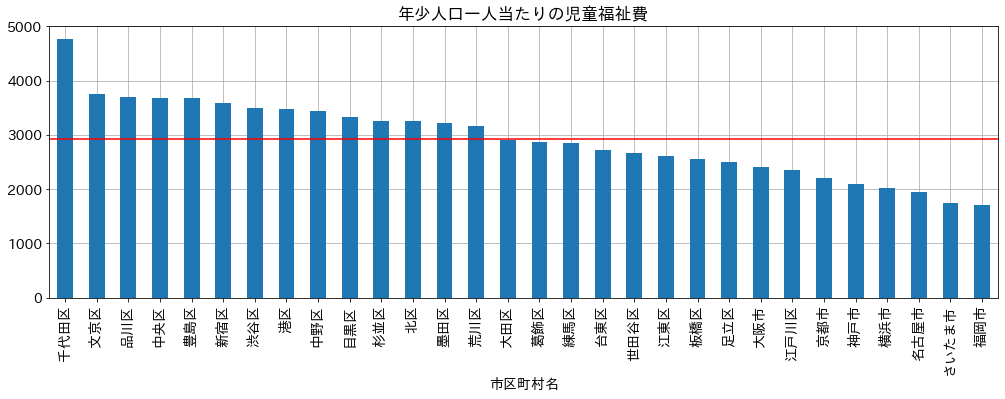

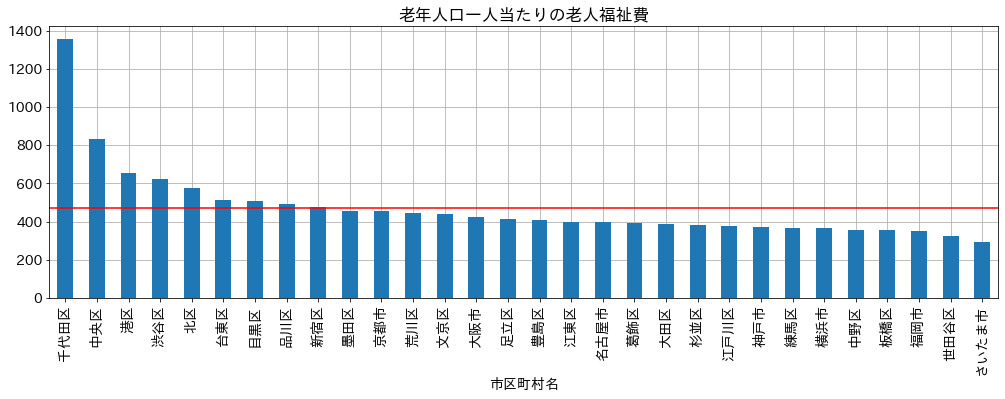

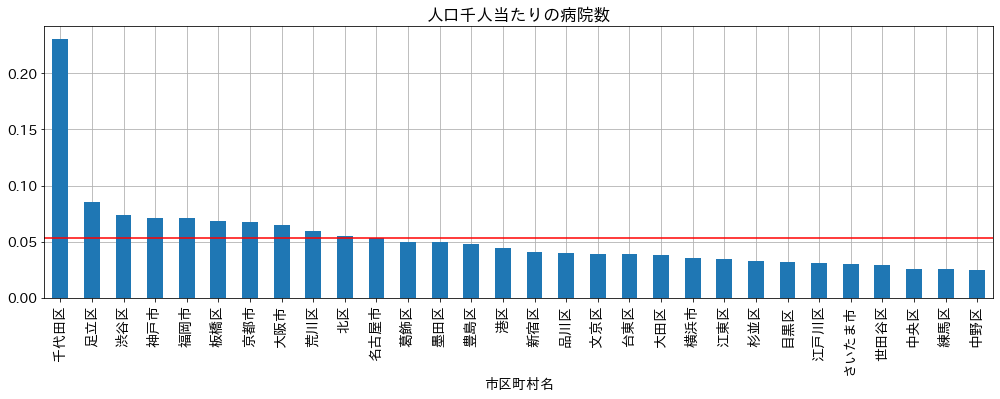

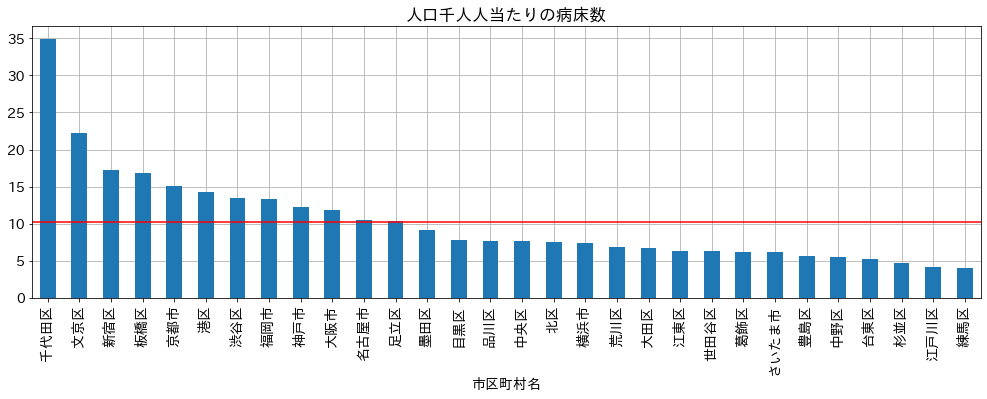

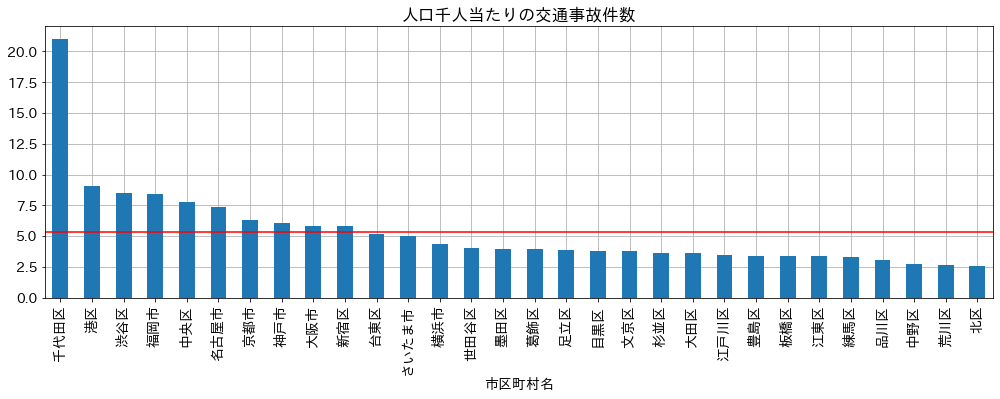

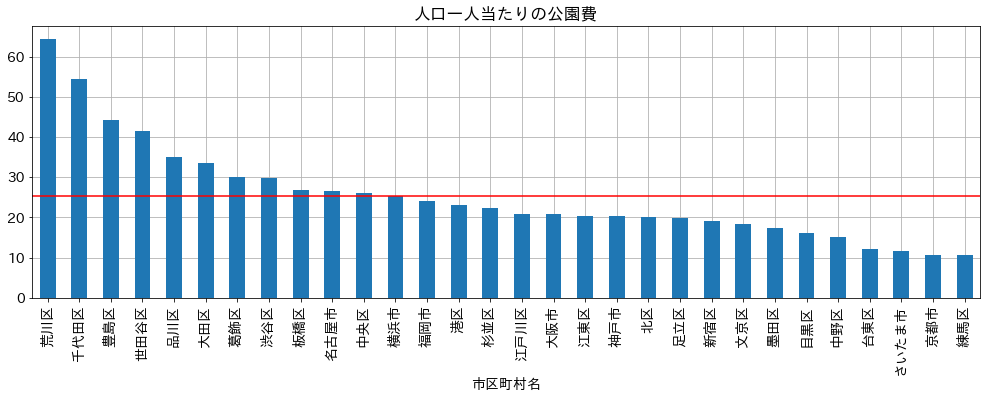

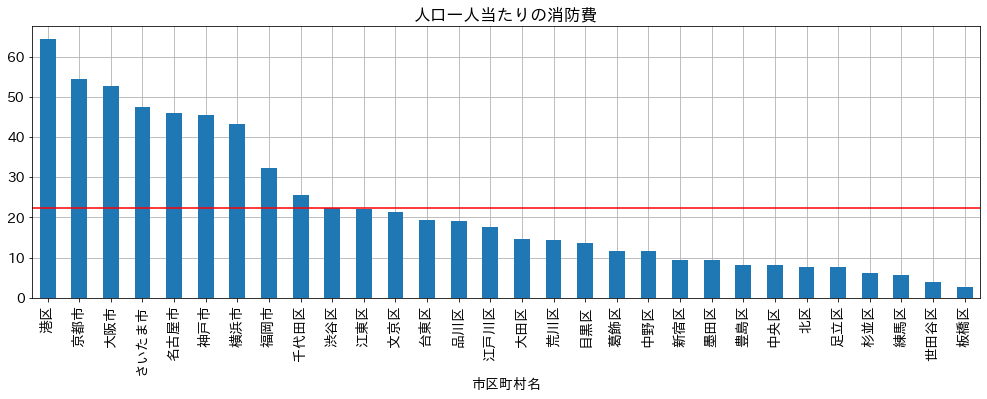

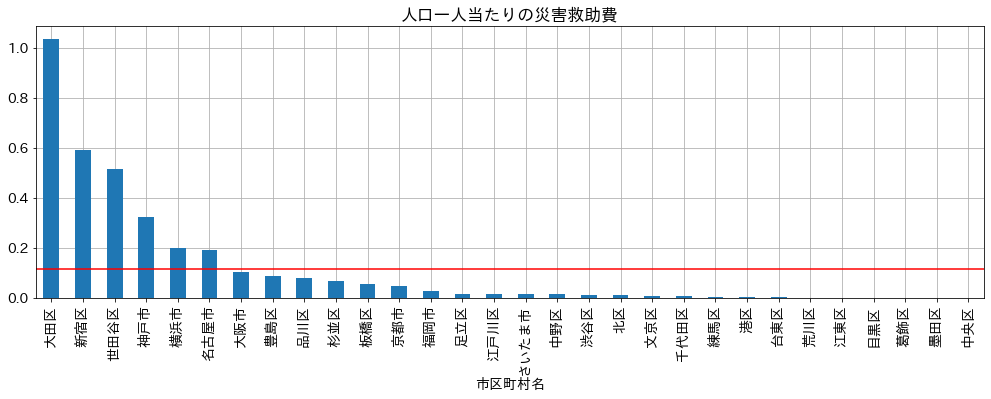

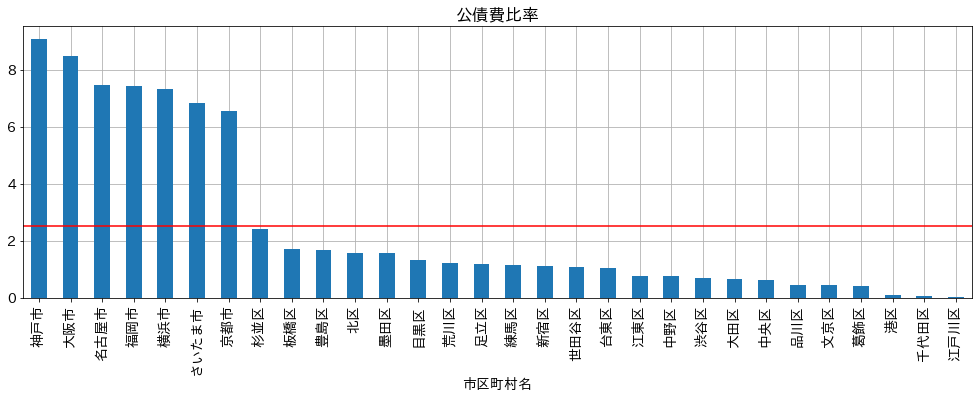

In [89]:
view_columns = [col for col in list(df_city_all.columns) if '当たり' in col] + ['公債費比率']
for col in view_columns:
    draw_bar_graph_by_city(df_big_city, col)